In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import pickle
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_pickle('processed_data.pk1')

In [5]:
df.dtypes

host_response_time              object
host_response_rate              object
host_is_superhost                int64
host_total_listings_count      float64
borough                         object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
price                          float64
security_deposit               float64
cleaning_fee                   float64
extra_people                   float64
minimum_nights                   int64
maximum_nights                   int64
availability_30                  int64
number_of_reviews                int64
review_scores_rating            object
review_scores_accuracy          object
review_scores_cleanliness       object
review_scores_checkin           object
review_scores_communication     object
review_scores_location          object
review_scores_value             object
instant_bookable         

In [6]:
# Establishting data sets for training
X = df.drop('price', axis=1)
y = df['price']

In [7]:
# Train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
num_col = X.select_dtypes(include=['int64', 'float64']).columns
cat_col = X.select_dtypes(include=['object']).columns

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_col),
    ('cat', cat_transformer, cat_col)
])

#### Fitting the estimator

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
alphavec = 10**np.linspace(-3, 3, 100)

In [10]:
def print_matrix(train_pred, test_pred):
    print('\nTraining r2: ', round(r2_score(y_train, train_pred), 4))
    print('Testing r2: ', round(r2_score(y_test, test_pred), 4))
    print('\nTraining MSE: ', round(mean_squared_error(y_train, train_pred), 4))
    print('Testing MSE: ', round(mean_squared_error(y_test, test_pred), 4))

In [227]:
# Linear regression
lr_est = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', LinearRegression())    
])

lr_est.fit(X_train, y_train)
lr_train_pred = lr_est.predict(X_train)
lr_test_pred = lr_est.predict(X_test)
print_matrix(lr_train_pred, lr_test_pred)


Training r2:  0.609
Testing r2:  0.521

Training MSE:  2901.2499
Testing MSE:  3313.5821


In [228]:
# Ridge regressor
ridge_est = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', RidgeCV(alphas = alphavec, cv=kf))
])

ridge_est.fit(X_train, y_train)
ridge_train_pred = ridge_est.predict(X_train)
ridge_test_pred = ridge_est.predict(X_test)
print('alpha: ', ridge_est[1].alpha_)
print_matrix(ridge_train_pred, ridge_test_pred)

alpha:  4.328761281083062

Training r2:  0.6078
Testing r2:  0.5243

Training MSE:  2910.1468
Testing MSE:  3291.1104


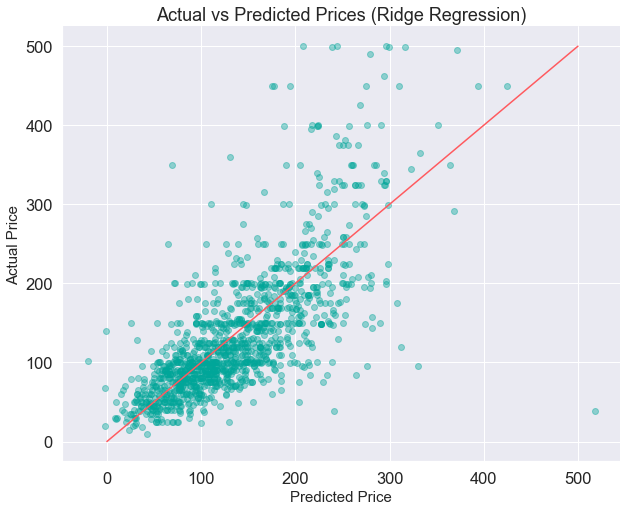

In [229]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,500], [0,500], c='#FF5A5F')
plt.scatter(ridge_test_pred, y_test, color='#00A699', alpha=0.4)
sns.despine()
plt.ylabel('Actual Price', size=15)
plt.xlabel('Predicted Price', size=15)
plt.title('Actual vs Predicted Prices (Ridge Regression)', size=18);
#plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

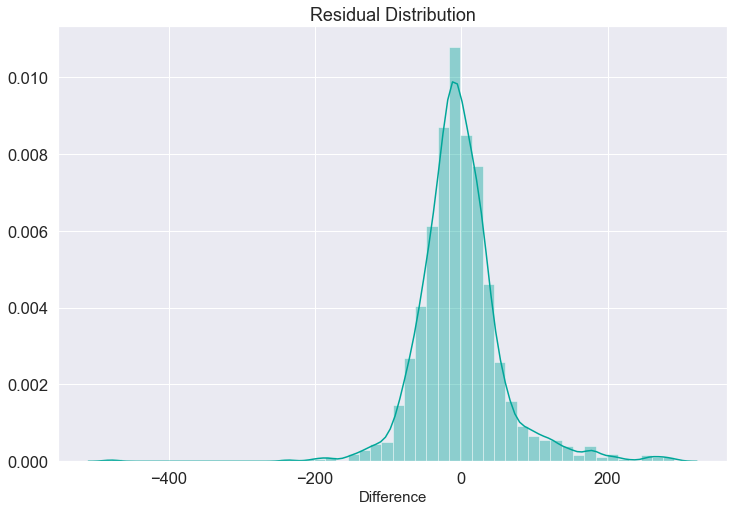

In [230]:
plt.figure(figsize=(12,8))
sns.distplot(y_test - ridge_test_pred, color='#00A699') 
plt.title('Residual Distribution', size = 18)
plt.xlabel('Difference', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

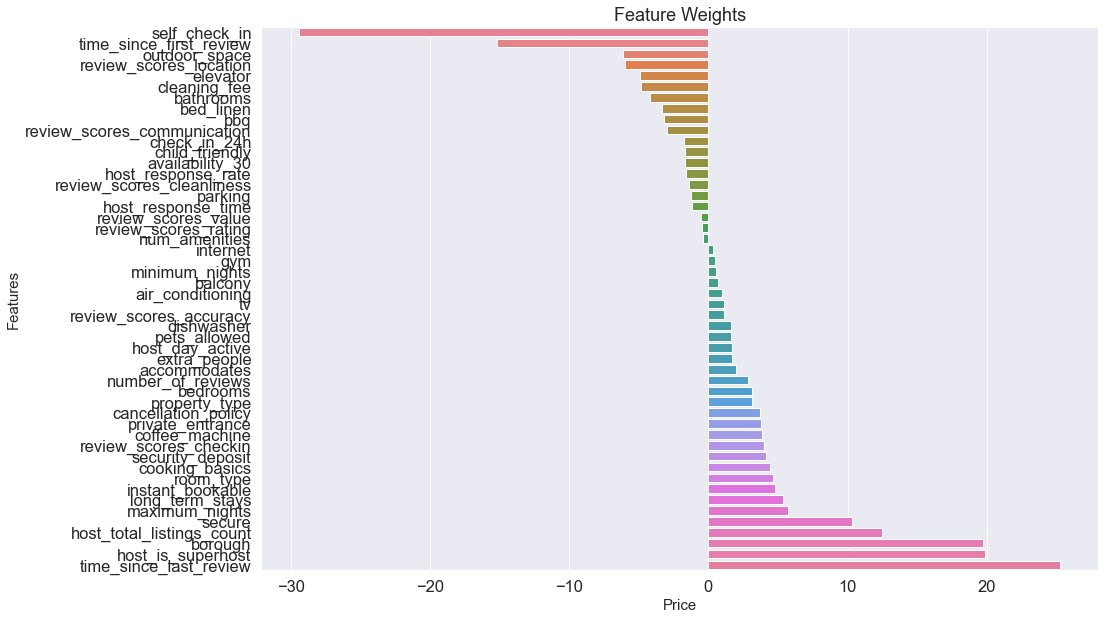

In [231]:
coef_list = sorted(list(zip(X_train.columns, ridge_est[1].coef_)), key= lambda x : x[1])

x_values = [x[0] for x in coef_list]
y_values = [y[1] for y in coef_list]

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=y_values, y=x_values, palette=("husl"))
#ax.set(xticks=xtick_list)
ax.set_title('Feature Weights', size=18)
ax.set_xlabel('Price', size=15)
ax.set_ylabel('Features', size=15)
plt.show()
#plt.savefig('features', bbox_inches ='tight', dpi = 400)

In [11]:
# Random Forest Regression
rf_est = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {'rf__n_estimators': [80],
              'rf__max_depth': [20]}

g_est = GridSearchCV(rf_est,
                     n_jobs=5,
                    param_grid=param_grid,
                    cv=5)

g_est.fit(X_train, y_train)
rf_train_pred = g_est.predict(X_train)
rf_test_pred = g_est.predict(X_test)
print_matrix(rf_train_pred, rf_test_pred)


Training r2:  0.9416
Testing r2:  0.6144

Training MSE:  429.7467
Testing MSE:  2759.0394


In [13]:
g_est.best_params_

{'rf__max_depth': 20, 'rf__n_estimators': 80}

In [14]:
rf_est.set_params(**g_est.best_params_).fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  Index(['host_is_superhost', 'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'security_deposit', 'cleaning_fee',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availabilit...
       'room_type', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'time_since_first_review',
       'time_since_last_

In [250]:
X_train.head()

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,borough,property_type,room_type,accommodates,bathrooms,bedrooms,...,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,time_since_first_review,time_since_last_review
2407,unknown,unknown,0,3.0,Broadway,Apartment,Entire home/apt,2,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2-5 years,6-12 months
6498,within an hour,100%,0,39.0,Wallingford,House,Private room,2,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,no reviews,no reviews
889,unknown,unknown,0,1.0,Lawton Park,Apartment,Entire home/apt,2,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2-5 years,1+ year
4044,within a few hours,100%,1,1.0,Whittier Heights,Other,Entire home/apt,2,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1-2 years,2-8 weeks
4105,within a day,50-89%,0,1.0,Brighton,Other,Entire home/apt,2,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1-2 years,2-8 weeks


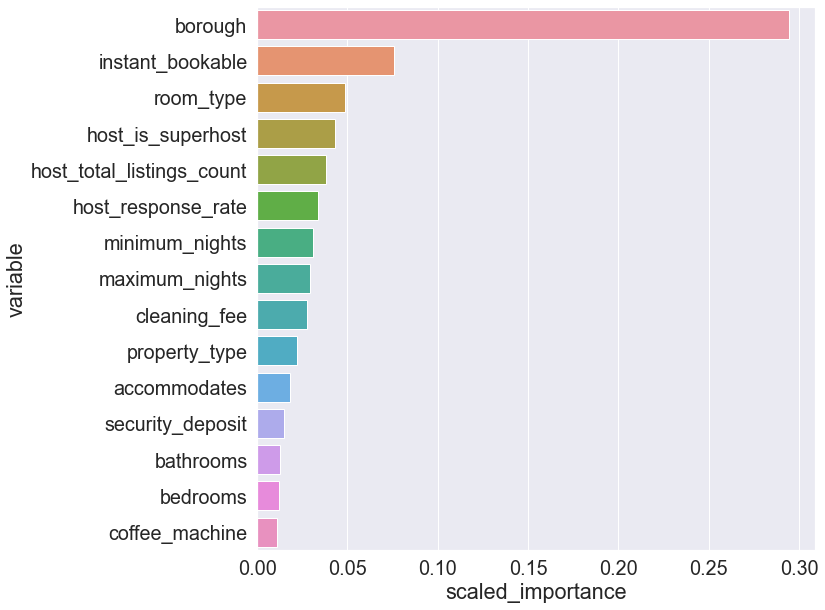

In [18]:
feature_importance = pd.DataFrame(list(zip(list(X_train.columns),rf_est['rf'].feature_importances_)),
                                  columns=['variable', 'scaled_importance']).sort_values(by='scaled_importance', ascending=False)
sns.set(font_scale=1.8)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='scaled_importance', y='variable', data=feature_importance.iloc[0:15])
#plt.show()
plt.savefig('feature_plot', bbox_inches ='tight', dpi = 400)

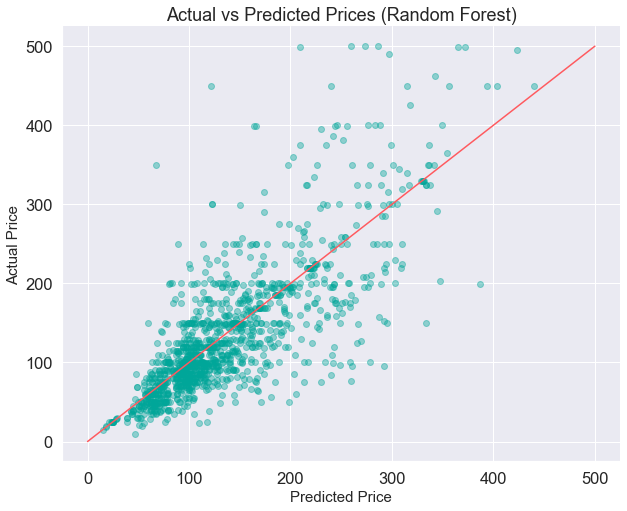

In [244]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,500], [0,500], c='#FF5A5F')
plt.scatter(rf_test_pred, y_test, color='#00A699', alpha=0.4)
sns.despine()
plt.ylabel('Actual Price', size=15)
plt.xlabel('Predicted Price', size=15)
plt.title('Actual vs Predicted Prices (Random Forest)', size=18);
#plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

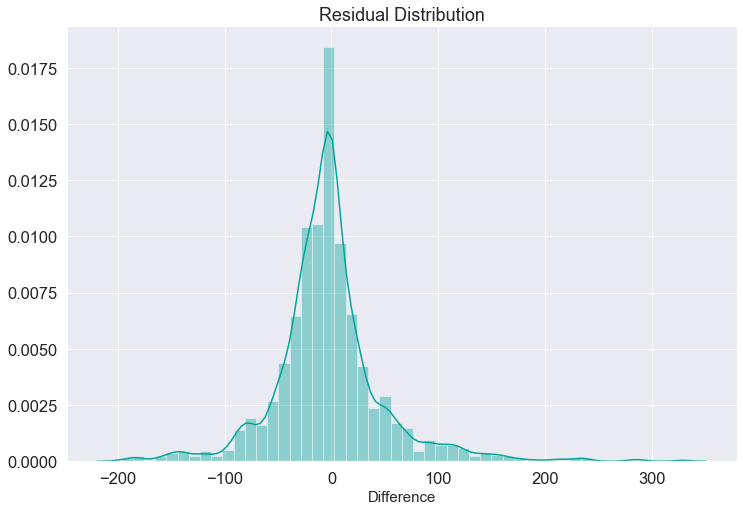

In [260]:
plt.figure(figsize=(12,8))
sns.distplot(y_test - rf_test_pred, color='#00A699') 
plt.title('Residual Distribution', size = 18)
plt.xlabel('Difference', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

In [239]:
xgb_est = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb_est', xgb.XGBRegressor())
])
xgb_est.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  Index(['host_is_superhost', 'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'security_deposit', 'cleaning_fee',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availabilit...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6,

In [241]:
xgb_train_pred = xgb_est.predict(X_train)
xgb_test_pred = xgb_est.predict(X_test)
print_matrix(xgb_train_pred, xgb_test_pred)


Training r2:  0.9407
Testing r2:  0.6122

Training MSE:  439.9221
Testing MSE:  2682.6356


In [200]:
ft_weights_xgb = pd.DataFrame(xgb['xgboost'].feature_importances_)

In [203]:
len(xgb['xgboost'].feature_importances_)

5317

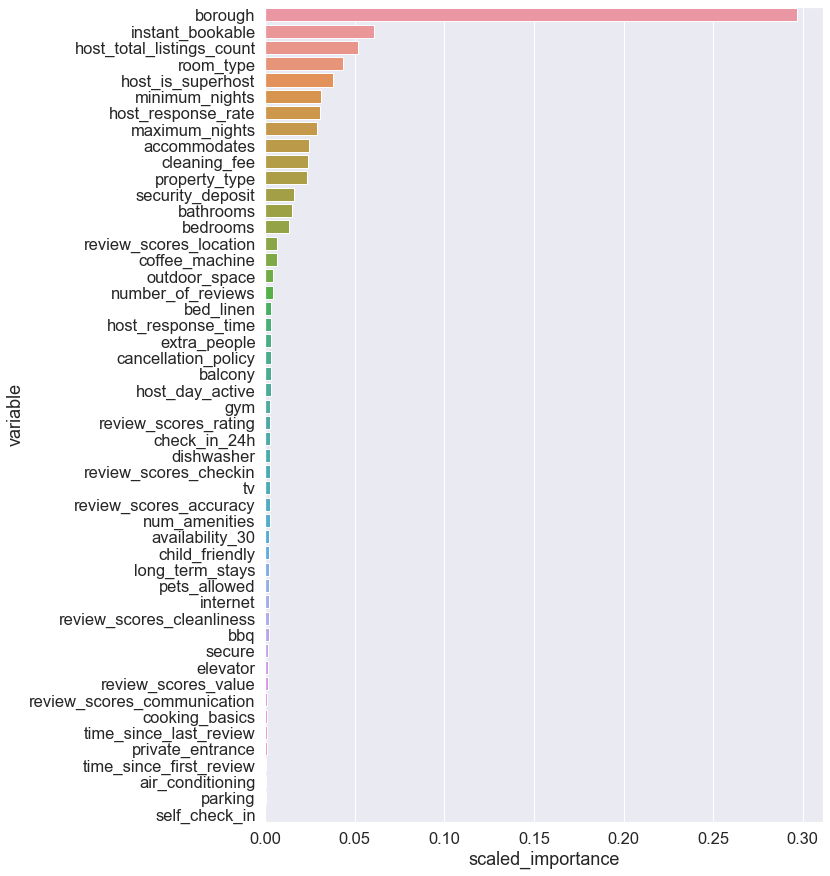

In [245]:
xgb_feature_importance = pd.DataFrame(list(zip(list(X_train.columns),xgb_est['xgb_est'].feature_importances_)),
                                  columns=['variable', 'scaled_importance']).sort_values(by='scaled_importance', ascending=False)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x='scaled_importance', y='variable', data=feature_importance)
plt.show()

In [259]:
df.describe()

,host_is_superhost,host_total_listings_count,accommodates,bathrooms,bedrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,gym,child_friendly,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in
count,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,...,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000,6408.000000
mean,0.429307,96.760612,3.637328,1.293149,1.382647,135.077091,214.788233,74.569444,12.156523,14.877185,...,0.149501,0.413858,0.785268,0.308989,0.982522,0.374220,0.225187,0.501248,0.175874,0.555556
std,0.495016,327.773744,2.190518,0.635811,0.965436,85.562457,412.903280,69.458014,20.070572,20.542313,...,0.356609,0.492562,0.410668,0.462113,0.131055,0.483959,0.417738,0.500037,0.380743,0.496943
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,1.000000,1.000000,76.000000,0.000000,30.000000,0.000000,2.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,3.000000,1.000000,1.000000,110.000000,100.000000,60.000000,5.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,8.000000,4.000000,1.500000,2.000000,175.000000,300.000000,100.000000,20.000000,30.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1766.000000,16.000000,16.000000,7.000000,500.000000,5000.000000,700.000000,300.000000,400.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


2